# Simple CSTR State-estimation: MHE
(By David T)

### 0. Introduction
In this example, the state-estimation of a simple CSTR reactor is demonstrated with the *CAPRESE* tools. For this model, a non-isothermal CSTR model is used. The kinetics represent the reaction between thiosulfate and hydrogen peroxide,
\begin{align}
\dfrac{dC_{A}}{dt} &= \dfrac{F}{V} \left(C_{A}^{in} - C_{A} \right) - 2k T_{R}C_{A}^{2} \\
\dfrac{dT_{R}}{dt} &= \dfrac{F}{V} \left(T_{R}^{in} - T_{R} \right) + \dfrac{2 \left(- \Delta H_{R} \right)k T_{R} C_{A}^{2}}{\rho C_{p}} - \dfrac{UA}{V \rho C_{p}} \left(T_{R} - T_{cw} \right) \\
\dfrac{dT_{cw}}{dt} &= \dfrac{F_{cw}}{V_{cw}} \left(T_{cw}^{in} - T_{cw} \right) + \dfrac{2 \left(- \Delta H_{R} \right)k T_{R} C_{A}^{2}}{\rho C_{p}} - \dfrac{UA}{V \rho C_{p}} \left(T_{R} - T_{cw} \right) \\
k \left(T_{R} \right) &= k_{0} \exp \left(\dfrac{-E_{a}}{RT_{R}} \right)
\end{align}
Where $C_{A}$ is the concentration of thiosulfate, $T_{R}$ is the reactor temperature and the cooling water temperature $T_{cw}$.  
For this problem, a simple MHE strategy will be used, that is a formulation as follows:
begin{equation} 
 \begin{split}
 \min_{x_{-\mathcal{N}},\mathbf{w}_{k}, \mathbf{v}_{k}} \quad & \Phi_{-\mathcal{N}} \left(x_{-\mathcal{N}|k}, x_{-\mathcal{N}|k-1}, \Pi _{-\mathcal{N}|k-1}\right)+  \\ &        \quad  +  \sum_{i=-\mathcal{N}}^{0} v_{i|k}^{T} \mathcal{R}^{-1}_{i} v_{i|k} + \sum_{i=-\mathcal{N}}^{-1}w^{T}_{i|k} \mathcal{Q}^{-1}_{i} w_{i|k}\\
 \text{s.t.} \quad  &x_{l+1|k} = f \left(x_{l|k}\right) + w_{l|k}, \quad l \in \left\lbrace -\mathcal{N},-\mathcal{N}+1,...,-1 \right\rbrace\\
 &y\left(k+l\right) = h \left(x_{l|k}\right) + v_{l|k}, \quad   l \in \left\lbrace -\mathcal{N},-\mathcal{N}+1,...,0 \right\rbrace\\
 &x_{l|k} \in \mathbb{X}, \quad l \in \left\lbrace -\mathcal{N},-\mathcal{N}+1,...,0 \right\rbrace\\
 &w_{l|k} \in \mathbb{W}, \quad l \in \left\lbrace -\mathcal{N},-\mathcal{N}+1,...,-1 \right\rbrace,\\
 \end{split}
 \end{equation}

where, $x$ correspond to states, $y$ the measurements, $v$ the measurement noise, and $w$ the plant disturbance.

### 1. MHE object set up

In [1]:
from nmpc_mhe.aux.utils import load_iguess
from nmpc_mhe.aux.utils import reconcile_nvars_mequations  #: counts n_var and m_equations from nl
from nmpc_mhe.pyomo_dae.MHEGen_pyDAE import MheGen_DAE
from sample_mods.cstr_rodrigo.cstr_c_nmpc import cstr_rodrigo_dae
from pyomo.environ import *
import matplotlib.pyplot as plt
import os, sys

With similar ideas in mind as the NMPC object set-up, a predefined model needs to have the appropriate ports for controls. Therefore, for the specific MHE problem, it is necessary to define the measurement variables.

In [2]:
measurements = ['T']

The remaining information corresponds to the state and control information. For this example it is declared to keep consistency.

In [3]:
states = ["Ca", "T", "Tj"]
controls = ["u1"]
u_bounds = {"u1": (200, 1000)}
state_bounds = {"Ca": (0.0, None), "T":(2.0E+02, None), "Tj":(2.0E+02, None)}
ref_state = {("Ca", (0,)): 0.010}

In [4]:
mod = cstr_rodrigo_dae(2,2)

In this way the MHE object can be created. 

In [5]:
e = MheGen_DAE(mod, 2, states, controls, states, measurements,
               u_bounds=u_bounds,
               ref_state=ref_state,
               override_solver_check=True,
               var_bounds=state_bounds,
               k_aug_executable='/home/dav0/in_dev_/WorkshopFraunHofer/caprese/k_aug/bin/k_aug')

New model at 140099238574912
New timebounds defined!
New model at 140099238630976
New timebounds defined!
Model: unknown Bounds activated
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
New model at 140099238276384
New model at 140099238383040
New timebounds defined!
New timebounds defined!
Model: LSMHE (Least-Squares MHE) Bounds activated


W0[[Initializing MHE]]The Q_MHE and R_MHE matrices are diagonal.


### 2. Preparation phase
The MHE problem requires more information to be constructed than  the NMPC; for instance weight matrices

In [6]:
Q = {}
U = {}
R = {}
Q['Ca'] = 1.11
Q['T'] = 99.0
Q['Tj'] = 1.1
U['u1'] = 0.22
R['T'] = 1.22
e.set_covariance_disturb(Q)
e.set_covariance_u(U)
e.set_covariance_meas(R)
e.lsmhe.U_mhe.pprint()
e.create_rh_sfx()

U_mhe : Size=5, Index=U_mhe_index, Domain=Any, Default=None, Mutable=True
    Key       : Value
    (0, 'u1') : 4.545454545454546
    (1, 'u1') : 4.545454545454546
    (2, 'u1') : 4.545454545454546
    (3, 'u1') : 4.545454545454546
    (4, 'u1') : 4.545454545454546


Then, it is necessary to load initial guesses.

In [7]:
e.get_state_vars()
e.load_iguess_steady()
load_iguess(e.SteadyRef, e.PlantSample, 0, 0)
e.solve_dyn(e.PlantSample)

{'Ca': [(0,)], 'T': [(0,)], 'Tj': [(0,)]}
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_steady_ref]]labels at 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]SteadyRef.--------------------
/tmp/tmpacle1sse.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                              bound_push = 1e-07                 yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                 

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


0

And finally start the preparation phase of the *mhe*

In [8]:
e.init_lsmhe_prep(e.PlantSample)
e.shift_mhe()
e.init_step_mhe()
e.solve_dyn(e.lsmhe,
            skip_update=False,
            max_cpu_time=600,
            ma57_pre_alloc=5, tag="lsmhe")  #: Pre-loaded mhe solve

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[init_lsmhe_prep]]Preparation phase MHE.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]Measurement to:0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpbbytuhb3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 y

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]Measurement to:2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpsl4iq5sp.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]Measurement to:3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp66v_1eep.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   ye

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total n

optimal


/tmp/tmpwbfo2hon.pyomo.nl -AMPL halt_on_ampl_error=yes 
Ipopt vanilla0: halt_on_ampl_error=yes
halt_on_ampl_error=yes


List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 1e-06                 yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 5                     yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 3000                  yes
                             mu_strategy = adaptive              yes
                             output_file = prep_mhe.txt          yes
                       print_info_string = yes                   yes
                      pri

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[initialize_lsmhe]]Attempting to initialize lsmhe Done.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp5o9msq8l.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300

optimal


/tmp/tmpqvzpeu1i.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 5                     yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 3000                  yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      513
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


0

In [9]:
e.check_active_bound_noisy()
e.load_covariance_prior()
e.set_state_covariance()

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.4993; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 129
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 17
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601034229527142 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033361066351 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 129, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 513
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 67
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000000
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 94
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


In [10]:
e.regen_objective_fun()  #: Regen erate the obj fun
e.deact_icc_mhe()  #: bRemove the initial conditions

In [11]:
ca = e.PlantSample.Ca[2, 0]
t = e.PlantSample.T[2, 0]
u = e.PlantSample.u1[2]
tj = e.PlantSample.Tj[2, 0]

ca_mhe = e.lsmhe.Ca[10, 0]
t_mhe = e.lsmhe.T[10, 0]
tj_mhe = e.lsmhe.Tj[10, 0]

spl = []
ul = []
cal = []
tl = []
tjl = []

ca_mhel = []
t_mhel = []
tj_mhel = []

### 4. Main state estimation loop

The main estimator loop for this example calculates the states under random noise. Then it basically:  
1. Generates noise
2. Simulates plant
2. Reads measurement
3. Initializes MHE
4. Attempts to solve MHE
5. Post optimality: prior-covariance
6. Cycle plant

In [12]:
for i in range(0, 60):  #: Five steps
    if i < 20:
        sigma = 0.0005
    elif 20 < i < 40:
        sigma = 0.0015
    else:
        sigma = 0.002
    e.noisy_plant_manager(sigma=sigma, action="apply", update_level=True)
    e.solve_dyn(e.PlantSample, stop_if_nopt=True)
    cal.append(value(ca))
    tl.append(value(t))
    tjl.append(value(tj))
    e.update_state_real()  # update the current state
    e.update_measurement()
    e.compute_y_offset()  #: Get the offset for y
    e.preparation_phase_mhe(as_strategy=False)

    stat = e.solve_dyn(e.lsmhe,
                       skip_update=False, iter_max=500,
                       jacobian_regularization_value=1e-04,
                       max_cpu_time=600, tag="lsmhe", keepsolve=False, wantparams=False)

    if stat == 1:  #: Try again
        e.lsmhe.write_nl(name="bad_mhe.nl")
        stat = e.solve_dyn(e.lsmhe,
                           skip_update=True,
                           max_cpu_time=600,
                           stop_if_nopt=True,
                           jacobian_regularization_value=1e-02,
                           linear_scaling_on_demand=True, tag="lsmhe")
        if stat != 0:
            sys.exit()
    e.update_state_mhe()  #: get the state from mhe
    ca_mhel.append(value(ca_mhe))
    t_mhel.append(value(t_mhe))
    tj_mhel.append(value(tj_mhe))
    #: At this point computing and loading the Covariance is not going to affect the sens update of MHE
    e.prior_phase()
    e.print_r_mhe()
    e.print_r_dyn()

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpjw4lp2ue.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpt2m7s2g0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


/tmp/tmpd4u6zt8f.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.82338; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-4.695417101885647 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-4.695417101885635 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 43810.239463
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        ineq

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpgesyvpg3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpa6opdmth.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.0740081; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033487432746 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103434583689 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000231
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpba0rvk06.pyomo.nl -AMPL 


optimal


/tmp/tmpcu4ke98i.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp75k9nd2i.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.490032; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033726490051 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330312611 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000591
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpgauwf83b.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmppkckjaj5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpukc311_y.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.536146; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033726826945 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033302361689 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000363
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpzegtpz02.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.40996; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727944445 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303765364 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000275
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpwbrp1u3r.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


/tmp/tmpo4shbpgf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpjgt_n1qu.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.469149; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727753109 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303380609 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000593
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total n

optimal


/tmp/tmp8p0z5qe3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpdx_3_oot.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.366964; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728302948 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033304068855 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000822
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:  

optimal


        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp1u0e7t96.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.424238; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372821885 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303954166 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000380
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpi3ud3tns.pyomo.nl -AMPL 


optimal


/tmp/tmpuhwub5cx.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpp7oufby8.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.446504; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727965358 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303632182 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000253
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp2m1g1xs1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


/tmp/tmpw47q7dxf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpx6k8on6y.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.308542; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728103586 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303863616 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000164
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp88l8_rlw.pyomo.nl -AMPL 


optimal



I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpl3ntv24r.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp5cb37nwg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.401799; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372865476 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033304496783 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000045
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpvugqm26d.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.421175; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728373485 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330405047 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000114
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpcc_80w7s.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


/tmp/tmp8bvvag0w.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmppxhnzpmn.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.459687; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728017011 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330372104 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000011
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmps_icr77t.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


/tmp/tmprdoy48yp.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpt8y0eksv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.45514; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728018345 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303848737 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000074
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp33j53mf9.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp15ab2t0q.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpfz7qhpum.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.499461; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727383486 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033302970826 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000112
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        ineq

optimal


/tmp/tmp9rcsh2_u.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpsq_plqhx.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.436379; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727957754 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303831494 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000605
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpguqswhtd.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp126_dleo.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.525797; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727040441 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330245479 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000235
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpn02br_2z.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpg8em9xsf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.470459; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372755611 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303355408 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000566
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total n

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:  

optimal


/tmp/tmpsfjqns4d.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.500319; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727368478 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033302888354 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000691
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpy5x85hu9.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpc6civa6v.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmprun4jass.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.380429; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728330968 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033304263371 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000944
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpsr09r5g2.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpz8l1_10j.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmptt8l3ke4.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.456703; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727920498 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303512281 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.002798
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpigyr4fph.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp1qtrbe41.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpgn8ulemf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.408865; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728512842 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330462216 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.002544
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpun7pjnu1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp6qk7_56k.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.458608; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727884642 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303411139 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.006102
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpwlp4xx_e.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpxvc9e16s.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp1_ggp_bj.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.272604; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033730073695 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033306801849 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.006828
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp36zzpc7m.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp8hm4xqcj.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.639813; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033725657175 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033300782547 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.002864
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp1jzv3trd.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


/tmp/tmpae7255i7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpfn6by9y4.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.605519; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033725202985 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033300970709 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.005073
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpeedtufis.pyomo.nl -AMPL 


optimal



I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp4b7unvy_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpbk43w3sv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.619958; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033724179365 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299813167 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001175
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpzbftgh4_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp4uot1z9b.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpc9amymkw.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.605143; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033722659118 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103329776256 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.002993
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total n

optimal


           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables..........................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpxr_ovo2f.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.594506; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033724959116 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330101569 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.007126
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpgwjptvs5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpas69ez6t.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.58049; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723457919 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033298674595 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.002308
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmprmznvbv4.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp2y1op68o.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp_gqt65yq.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.617557; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033725240905 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033301006641 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.004058
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpp4b9fede.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpxwbhm2sm.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpl_gj0oss.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.5879; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372559555 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033301595916 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.005855
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


/tmp/tmp7dyjwkm7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpbsnkn1ne.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.588683; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723002896 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033298087955 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.004795
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpm2xleaol.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.611643; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033724696606 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033300577889 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.007533
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp7csl7jri.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmps5j5ilmc.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpcs7sxn9g.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.60896; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372472915 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330048062 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.011212
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpdqvhz2yx.pyomo.nl -AMPL 


optimal


/tmp/tmpokvq65ao.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpyn9w92he.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.632655; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723692108 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299153666 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.012494
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


/tmp/tmp6vbmka3h.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp8pp_yfmq.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.615573; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033724117427 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299876804 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.010756
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp73pc8lbg.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp473uoe7k.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmplpnaw2_n.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.619973; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372365113 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299241175 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.006364
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp7hswvhj3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp74xwokvt.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.630422; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033722498684 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033297963973 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.005761
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp_hja5cxx.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


/tmp/tmpuwcbao9u.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp6nymbkp1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.633021; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372209559 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033297497839 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.005448
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpf60se30n.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables..........................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpluhyxolb.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.646906; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033721924932 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033297215695 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.007453
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpkh0i3cc6.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal



-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpw3jetlkj.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt      

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp17_tk7r7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.626496; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723158745 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033298874059 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.011640
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmplzgn24x3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpvsv70ik5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp4cear4fa.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.62557; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723577245 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299226192 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.016460
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmppfd1kiao.pyomo.nl -AMPL 


optimal


/tmp/tmpu7o3kjk0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpg9q6adda.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.615815; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723879508 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299659091 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.020689
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpzcx1rs74.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


/tmp/tmpivxxql0f.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.616635; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723705235 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299370515 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.010212
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpnksowxar.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


/tmp/tmpma4_5djf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpwukang5a.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.625654; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033722519416 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.6010332979665 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.017990
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


/tmp/tmp702tqt6n.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp81gkuu5q.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.616057; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033722202146 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033297882989 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.015444
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568362661.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp7lfr5t4e.pyomo.nl -AMPL 


optimal


        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp3opq0lxh.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.673604; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033719779982 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033294599777 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.006893
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


/tmp/tmppo9msuw0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


/tmp/tmpnbpwl_di.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.616689; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033722375819 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033298294482 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.003675
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:  

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpjbk8zfbo.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.63233; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033721346777 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033296560077 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.014732
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables..........................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp261amju6.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.638877; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033721011307 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033296414501 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.031100
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp1voyyg_0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpvkohvs_i.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.654488; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033722353334 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033297943264 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.023120
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpibebc7o0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.594922; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033724708959 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033300778285 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.014217
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

optimal


/tmp/tmpdvd4jz_x.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.608601; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723172884 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033298886962 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.013489
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpeg_pehq9.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp4swrb1d2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp3auizl0a.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.641488; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033719483945 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033294413098 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.008990
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmptpovyq7p.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp_1qbddny.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.653341; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033719255152 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033294363624 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.009073
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp4ue527xx.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp2hdq7s7f.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpfr3lkht6.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.632605; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033721271186 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033296926651 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.003468
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpguvngbh8.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpaz414qb2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpe1h81jbm.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.659635; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372127585 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033296369804 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000127
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpaqxv8408.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal



-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp8vcxdant.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt      

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpv4h84kw6.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.640501; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033722508348 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033298048039 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000122
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmph47shqzr.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpx5m6wy48.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpki5u1q8c.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.648864; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033722421322 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033297700035 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.002044
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


In [13]:
err_ca = [abs(ca_mhel[i] - cal[i])/cal[i] for i in range(0, len(cal))]
err_t = [abs(t_mhel[i] - tl[i])/tl[i] for i in range(0, len(tl))]
err_tj = [abs(tj_mhel[i] - tjl[i])/tjl[i] for i in range(0, len(tjl))]

### 5. Results

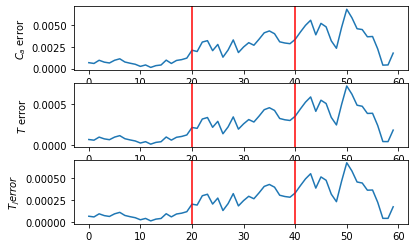

In [14]:
ax1 = plt.subplot(3, 1, 1)
plt.plot(err_ca)
plt.ylabel("$C_{a}$ error")
plt.axvline(x=20, color="r")
plt.axvline(x=40, color="r")


plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(err_t)
plt.ylabel("$T$ error")
plt.axvline(x=20, color="r")
plt.axvline(x=40, color="r")


plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(err_tj)
plt.ylabel("$T_{j} error$")
plt.axvline(x=20, color="r")
plt.axvline(x=40, color="r")
plt.show()

### Credits:
 - David Thierry (Carnegie Mellon University @2019)